# IMPORT LIBRARIES

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pmdarima as pmd
import holidays
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# IMPORT DATASET

In [2]:
file = "C:\\Users\\Republic Of Gamers\\OneDrive - Asia Pacific University\\archive\\Bakery sales.csv"
df = pd.read_csv(file)
df.head()

,Unnamed: 0,date,time,ticket_number,article,Quantity,unit_price
0,0,2021-01-02,08:38,150040.0,BAGUETTE,1.0,"0,90 €"
1,1,2021-01-02,08:38,150040.0,PAIN AU CHOCOLAT,3.0,"1,20 €"
2,4,2021-01-02,09:14,150041.0,PAIN AU CHOCOLAT,2.0,"1,20 €"
3,5,2021-01-02,09:14,150041.0,PAIN,1.0,"1,15 €"
4,8,2021-01-02,09:25,150042.0,TRADITIONAL BAGUETTE,5.0,"1,20 €"


# PRE-PROCESSING

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234005 entries, 0 to 234004
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Unnamed: 0     234005 non-null  int64  
 1   date           234005 non-null  object 
 2   time           234005 non-null  object 
 3   ticket_number  234005 non-null  float64
 4   article        234005 non-null  object 
 5   Quantity       234005 non-null  float64
 6   unit_price     234005 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 12.5+ MB


In [4]:
df.describe()

,Unnamed: 0,ticket_number,Quantity
count,234005.000000,234005.000000,234005.000000
mean,255205.035854,219201.258738,1.538377
std,147501.625992,40053.223896,1.289603
min,0.000000,150040.000000,-200.000000
25%,127979.000000,184754.000000,1.000000
50%,254573.000000,218807.000000,1.000000
75%,382911.000000,253927.000000,2.000000
max,511395.000000,288913.000000,200.000000


In [5]:
df.drop(columns=['Unnamed: 0'], errors='ignore', inplace = True, axis = 1)

In [6]:
df = df.rename(columns = {'article': 'pastries'})

In [7]:
df['ticket_number'] = df['ticket_number'].astype(str)
df['date'] = pd.to_datetime(df['date'])
df['time'] = pd.to_datetime(df['time'], format = "%H:%M").dt.time

In [8]:
df["price"] = df["unit_price"].str.replace("€", "")
df["currency"] = "€"
df['price'] = df['price'].str.replace(',', '.').astype(float)

In [9]:
df['time'].head()

0    08:38:00
1    08:38:00
2    09:14:00
3    09:14:00
4    09:25:00
Name: time, dtype: object

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234005 entries, 0 to 234004
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   date           234005 non-null  datetime64[ns]
 1   time           234005 non-null  object        
 2   ticket_number  234005 non-null  object        
 3   pastries       234005 non-null  object        
 4   Quantity       234005 non-null  float64       
 5   unit_price     234005 non-null  object        
 6   price          234005 non-null  float64       
 7   currency       234005 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 14.3+ MB


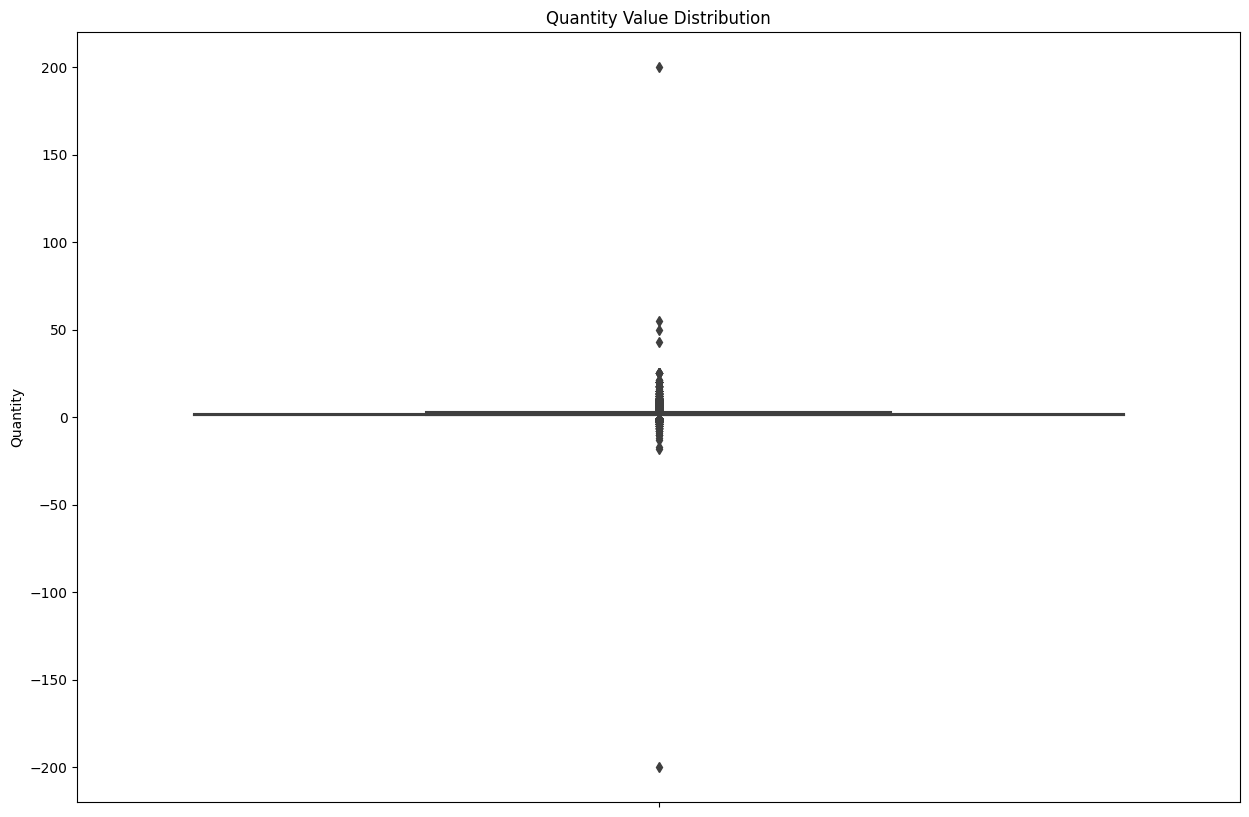

In [11]:
plt.figure(figsize=(15, 10))
sns.boxplot(y=df['Quantity'])
plt.title('Quantity Value Distribution')
plt.xticks(rotation=90)
plt.show()

In [12]:
negativeQuantity = df[df['Quantity'] < 0]
negativeTicketNum= negativeQuantity['ticket_number'].unique()
negativeTransactions = df[df['ticket_number'].isin(negativeTicketNum)]
negativeTransSorted = negativeTransactions.sort_values(by='ticket_number')
print(negativeTransSorted.head(50))

           date      time ticket_number              pastries  Quantity  \
448  2021-01-03  10:41:00      150265.0              BAGUETTE      -1.0   
1162 2021-01-05  19:00:00      150738.0         SPECIAL BREAD      -1.0   
1163 2021-01-05  19:00:00      150738.0     DIVERS PATISSERIE      -1.0   
1164 2021-01-05  19:00:00      150738.0    DIVERS BOULANGERIE      -1.0   
1467 2021-01-08  11:58:00      150941.0                 COUPE      -1.0   
1468 2021-01-08  11:58:00      150941.0            BOULE 400G      -1.0   
1469 2021-01-08  11:58:00      150941.0             CROISSANT      -4.0   
1470 2021-01-08  11:58:00      150941.0      PAIN AU CHOCOLAT      -2.0   
1845 2021-01-09  13:23:00      151163.0      FORMULE SANDWICH      -1.0   
1843 2021-01-09  13:23:00      151163.0     GAL FRANGIPANE 4P       1.0   
1844 2021-01-09  13:23:00      151163.0      FORMULE SANDWICH       3.0   
2043 2021-01-10  11:43:00      151280.0             VIK BREAD      -1.0   
2044 2021-01-10  11:43:00

In [13]:
df = df.drop(df[df['Quantity'] < 0].index)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 232710 entries, 0 to 234004
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   date           232710 non-null  datetime64[ns]
 1   time           232710 non-null  object        
 2   ticket_number  232710 non-null  object        
 3   pastries       232710 non-null  object        
 4   Quantity       232710 non-null  float64       
 5   unit_price     232710 non-null  object        
 6   price          232710 non-null  float64       
 7   currency       232710 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 16.0+ MB


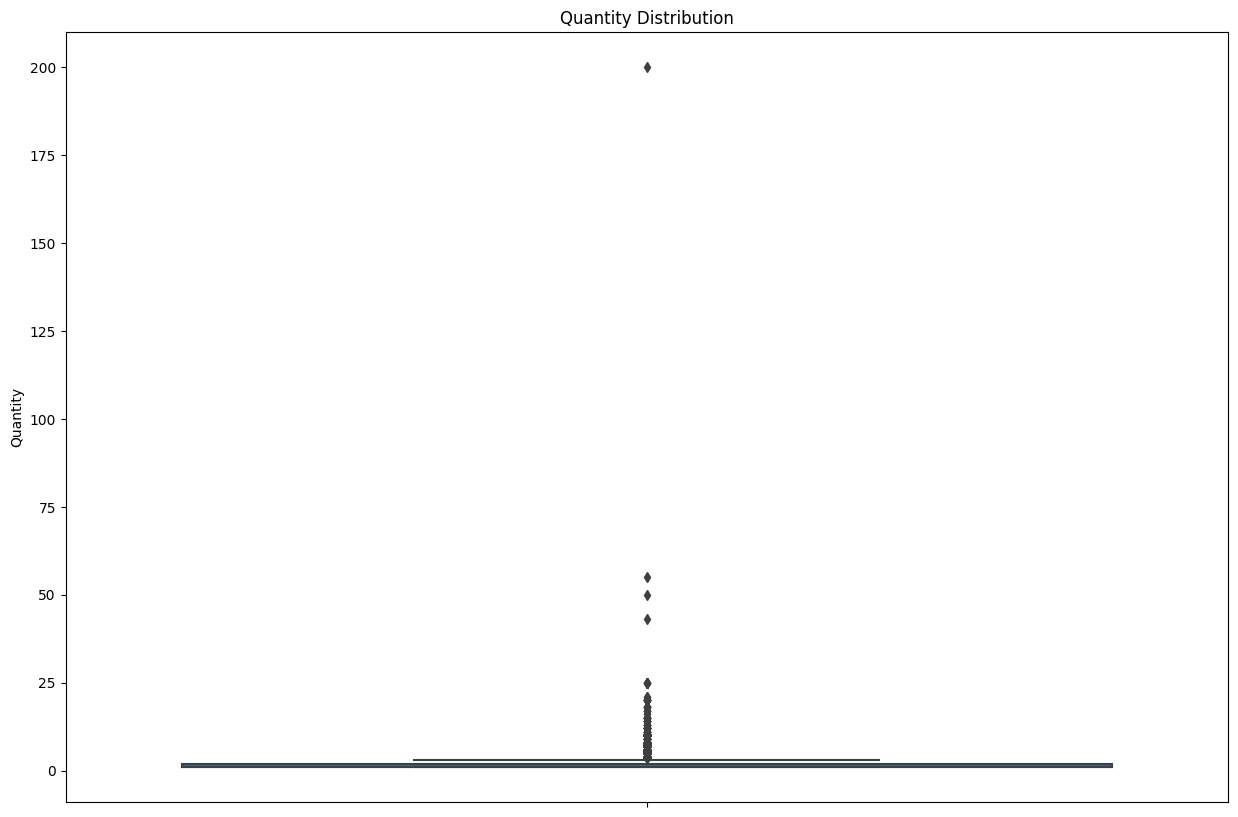

In [15]:
plt.figure(figsize=(15, 10))
sns.boxplot(y=df['Quantity'])
plt.title('Quantity Distribution')
plt.xticks(rotation=90)
plt.show()

In [16]:
df.describe()

,date,Quantity,price
count,232710,232710.000000,232710.000000
mean,2021-11-30 07:28:11.633363200,1.556396,1.659494
min,2021-01-02 00:00:00,1.000000,0.000000
25%,2021-07-03 00:00:00,1.000000,1.100000
50%,2021-11-03 00:00:00,1.000000,1.200000
75%,2022-05-31 00:00:00,2.000000,1.500000
max,2022-09-30 00:00:00,200.000000,60.000000
std,NaN,1.197990,1.718182


In [17]:
quantile1, quantile3 = np.quantile(df['Quantity'], [0.25,0.75])
print(quantile1,quantile3)

1.0 2.0


In [18]:
iqr = quantile3 -quantile1
print(iqr)

1.0


In [19]:
lowerBound = quantile1 - (1.5 * iqr)
upperBound = quantile3 + (1.5 * iqr)
print (lowerBound,upperBound)

-0.5 3.5


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 232710 entries, 0 to 234004
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   date           232710 non-null  datetime64[ns]
 1   time           232710 non-null  object        
 2   ticket_number  232710 non-null  object        
 3   pastries       232710 non-null  object        
 4   Quantity       232710 non-null  float64       
 5   unit_price     232710 non-null  object        
 6   price          232710 non-null  float64       
 7   currency       232710 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 16.0+ MB


In [21]:
outliers = df[df['Quantity'] > upperBound]
outliersAmt = outliers.shape[0]
outliersAmt

12954

In [22]:
df.set_index('date', inplace = True)

In [23]:
df.head()

,time,ticket_number,pastries,Quantity,unit_price,price,currency
date,,,,,,,
2021-01-02,08:38:00,150040.0,BAGUETTE,1.0,"0,90 €",0.90,€
2021-01-02,08:38:00,150040.0,PAIN AU CHOCOLAT,3.0,"1,20 €",1.20,€
2021-01-02,09:14:00,150041.0,PAIN AU CHOCOLAT,2.0,"1,20 €",1.20,€
2021-01-02,09:14:00,150041.0,PAIN,1.0,"1,15 €",1.15,€
2021-01-02,09:25:00,150042.0,TRADITIONAL BAGUETTE,5.0,"1,20 €",1.20,€


In [24]:
pastriesSold = df['Quantity'].groupby(df['pastries']).sum().reset_index()
pastriesSold = pastriesSold.sort_values(by = 'Quantity', ascending = False).reset_index(drop = True)
pd.set_option('display.max_rows', None)
pastriesSold.head(5)

,pastries,Quantity
0,TRADITIONAL BAGUETTE,118093.0
1,CROISSANT,29822.0
2,PAIN AU CHOCOLAT,25367.0
3,COUPE,23601.0
4,BANETTE,22870.0


## FEATURE ENGINEERING

In [25]:
df['total'] = df['Quantity'] * df['price']

In [26]:
df.index = pd.to_datetime(df.index)
df['dayOfTheWeek'] = df.index.to_series().dt.day_name()
df['hour'] = df['time'].apply(lambda x: x.hour)

In [27]:
df.head()

,time,ticket_number,pastries,Quantity,unit_price,price,currency,total,dayOfTheWeek,hour
date,,,,,,,,,,
2021-01-02,08:38:00,150040.0,BAGUETTE,1.0,"0,90 €",0.90,€,0.90,Saturday,8
2021-01-02,08:38:00,150040.0,PAIN AU CHOCOLAT,3.0,"1,20 €",1.20,€,3.60,Saturday,8
2021-01-02,09:14:00,150041.0,PAIN AU CHOCOLAT,2.0,"1,20 €",1.20,€,2.40,Saturday,9
2021-01-02,09:14:00,150041.0,PAIN,1.0,"1,15 €",1.15,€,1.15,Saturday,9
2021-01-02,09:25:00,150042.0,TRADITIONAL BAGUETTE,5.0,"1,20 €",1.20,€,6.00,Saturday,9


In [28]:
byDay = df.groupby('dayOfTheWeek')['Quantity'].sum()
byHour = df.groupby('hour')['Quantity'].sum()

In [29]:
print(byDay)

dayOfTheWeek
Friday       48439.0
Monday       48013.0
Saturday     62249.0
Sunday       83699.0
Thursday     45212.0
Tuesday      42802.0
Wednesday    31775.0
Name: Quantity, dtype: float64


In [30]:
print(byHour)

hour
7     13526.0
8     50661.0
9     57877.0
10    64826.0
11    69559.0
12    52587.0
13     8812.0
14      259.0
15      140.0
16    12463.0
17    16249.0
18    13709.0
19     1513.0
20        8.0
Name: Quantity, dtype: float64


In [31]:
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
byDay = byDay.reindex(days_order)

In [32]:
dfCopy = df.copy()

In [33]:
dfCopy.drop(columns=['time','hour','dayOfTheWeek','ticket_number','pastries','unit_price','currency'], inplace = True)

In [34]:
dailyDf = dfCopy.resample('D').sum()

In [35]:
dailyDf.head()

,Quantity,price,total
date,,,
2021-01-02,581.0,716.95,987.85
2021-01-03,565.0,781.95,1015.20
2021-01-04,315.0,340.00,461.90
2021-01-05,312.0,414.25,526.10
2021-01-06,0.0,0.00,0.00


In [36]:
dailyQuantity = df['Quantity'].resample('D').sum()
dailySales = df['total'].resample('D').sum()
weeklySales = dailySales.resample('W').sum()

In [37]:
dailyDf.head(5)

,Quantity,price,total
date,,,
2021-01-02,581.0,716.95,987.85
2021-01-03,565.0,781.95,1015.20
2021-01-04,315.0,340.00,461.90
2021-01-05,312.0,414.25,526.10
2021-01-06,0.0,0.00,0.00


In [38]:
wednesday_sales = df[df.index.day_name() == 'Wednesday']

# Display quantity sold specifically on Wednesday
print("Quantity sold on Wednesday:")
print(wednesday_sales[['Quantity']])

Quantity sold on Wednesday:
            Quantity
date                
2021-04-14       3.0
2021-04-14       1.0
2021-04-14       1.0
2021-04-14       1.0
2021-04-14       1.0
2021-04-14       1.0
2021-04-14       2.0
2021-04-14       1.0
2021-04-14       1.0
2021-04-14       1.0
2021-04-14       1.0
2021-04-14       1.0
2021-04-14       1.0
2021-04-14       1.0
2021-04-14       1.0
2021-04-14       1.0
2021-04-14       4.0
2021-04-14       1.0
2021-04-14       1.0
2021-04-14       2.0
2021-04-14       3.0
2021-04-14       3.0
2021-04-14       4.0
2021-04-14       7.0
2021-04-14       4.0
2021-04-14       1.0
2021-04-14       2.0
2021-04-14       4.0
2021-04-14       1.0
2021-04-14       1.0
2021-04-14       1.0
2021-04-14       1.0
2021-04-14       1.0
2021-04-14       3.0
2021-04-14       1.0
2021-04-14       1.0
2021-04-14       1.0
2021-04-14       1.0
2021-04-14       1.0
2021-04-14       1.0
2021-04-14       1.0
2021-04-14       1.0
2021-04-14       1.0
2021-04-14       1.0
2021-0

In [39]:
#create holiday column
holidayYears = [2021,2022,2023,2024]
frHolidays = {}

for year in holidayYears:
    franceHoliday = holidays.France(years = year)
    frHolidays.update(franceHoliday)

for date,name in sorted(frHolidays.items()):
    print(date,name)

2021-01-01 Jour de l'an
2021-04-05 Lundi de Pâques
2021-05-01 Fête du Travail
2021-05-08 Fête de la Victoire
2021-05-13 Ascension
2021-05-24 Lundi de Pentecôte
2021-07-14 Fête nationale
2021-08-15 Assomption
2021-11-01 Toussaint
2021-11-11 Armistice
2021-12-25 Noël
2022-01-01 Jour de l'an
2022-04-18 Lundi de Pâques
2022-05-01 Fête du Travail
2022-05-08 Fête de la Victoire
2022-05-26 Ascension
2022-06-06 Lundi de Pentecôte
2022-07-14 Fête nationale
2022-08-15 Assomption
2022-11-01 Toussaint
2022-11-11 Armistice
2022-12-25 Noël
2023-01-01 Jour de l'an
2023-04-10 Lundi de Pâques
2023-05-01 Fête du Travail
2023-05-08 Fête de la Victoire
2023-05-18 Ascension
2023-05-29 Lundi de Pentecôte
2023-07-14 Fête nationale
2023-08-15 Assomption
2023-11-01 Toussaint
2023-11-11 Armistice
2023-12-25 Noël
2024-01-01 Jour de l'an
2024-04-01 Lundi de Pâques
2024-05-01 Fête du Travail
2024-05-08 Fête de la Victoire
2024-05-09 Ascension
2024-05-20 Lundi de Pentecôte
2024-07-14 Fête nationale
2024-08-15 Assom

In [40]:
holidays_set = set(frHolidays.keys())
df['frHoliday'] = df.index.isin(holidays_set)
df.head(5)

C:\Users\Republic Of Gamers\AppData\Local\Temp\ipykernel_33920\1533076613.py:2: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df['frHoliday'] = df.index.isin(holidays_set)


,time,ticket_number,pastries,Quantity,unit_price,price,currency,total,dayOfTheWeek,hour,frHoliday
date,,,,,,,,,,,
2021-01-02,08:38:00,150040.0,BAGUETTE,1.0,"0,90 €",0.90,€,0.90,Saturday,8,False
2021-01-02,08:38:00,150040.0,PAIN AU CHOCOLAT,3.0,"1,20 €",1.20,€,3.60,Saturday,8,False
2021-01-02,09:14:00,150041.0,PAIN AU CHOCOLAT,2.0,"1,20 €",1.20,€,2.40,Saturday,9,False
2021-01-02,09:14:00,150041.0,PAIN,1.0,"1,15 €",1.15,€,1.15,Saturday,9,False
2021-01-02,09:25:00,150042.0,TRADITIONAL BAGUETTE,5.0,"1,20 €",1.20,€,6.00,Saturday,9,False


In [41]:
holidayTrue = df[df['frHoliday'] == True]

In [42]:
#time series features
def tsFeature(df):
    df = df.copy()
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['quarter'] = df.index.quarter
    df['dayofweek'] = df.index.dayofweek
    df['dayofyear'] = df.index.dayofyear
    df['day'] = df.index.day
    return df

dailyDf = tsFeature(dailyDf)
df = tsFeature(df)

In [43]:
df.head()

,time,ticket_number,pastries,Quantity,unit_price,price,currency,total,dayOfTheWeek,hour,frHoliday,month,year,quarter,dayofweek,dayofyear,day
date,,,,,,,,,,,,,,,,,
2021-01-02,08:38:00,150040.0,BAGUETTE,1.0,"0,90 €",0.90,€,0.90,Saturday,8,False,1,2021,1,5,2,2
2021-01-02,08:38:00,150040.0,PAIN AU CHOCOLAT,3.0,"1,20 €",1.20,€,3.60,Saturday,8,False,1,2021,1,5,2,2
2021-01-02,09:14:00,150041.0,PAIN AU CHOCOLAT,2.0,"1,20 €",1.20,€,2.40,Saturday,9,False,1,2021,1,5,2,2
2021-01-02,09:14:00,150041.0,PAIN,1.0,"1,15 €",1.15,€,1.15,Saturday,9,False,1,2021,1,5,2,2
2021-01-02,09:25:00,150042.0,TRADITIONAL BAGUETTE,5.0,"1,20 €",1.20,€,6.00,Saturday,9,False,1,2021,1,5,2,2


In [44]:
df.to_csv('bakerySalesProcessed.csv')

In [45]:
dailyDf.head(5)

,Quantity,price,total,month,year,quarter,dayofweek,dayofyear,day
date,,,,,,,,,
2021-01-02,581.0,716.95,987.85,1,2021,1,5,2,2
2021-01-03,565.0,781.95,1015.20,1,2021,1,6,3,3
2021-01-04,315.0,340.00,461.90,1,2021,1,0,4,4
2021-01-05,312.0,414.25,526.10,1,2021,1,1,5,5
2021-01-06,0.0,0.00,0.00,1,2021,1,2,6,6


In [46]:
df.shape

(232710, 17)

In [47]:
dailyDf['frHoliday'] = dailyQuantity.index.isin(holidays_set)

C:\Users\Republic Of Gamers\AppData\Local\Temp\ipykernel_33920\796488098.py:1: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  dailyDf['frHoliday'] = dailyQuantity.index.isin(holidays_set)


In [48]:
dailyDf.head(5)

,Quantity,price,total,month,year,quarter,dayofweek,dayofyear,day,frHoliday
date,,,,,,,,,,
2021-01-02,581.0,716.95,987.85,1,2021,1,5,2,2,False
2021-01-03,565.0,781.95,1015.20,1,2021,1,6,3,3,False
2021-01-04,315.0,340.00,461.90,1,2021,1,0,4,4,False
2021-01-05,312.0,414.25,526.10,1,2021,1,1,5,5,False
2021-01-06,0.0,0.00,0.00,1,2021,1,2,6,6,False


In [49]:
#function to create time lags
def createLags(df):
    df['quantityYesterday'] = df['Quantity'].shift(+1)
    df['quantitylag2'] = df['Quantity'].shift(+2)
    df['quantitylag3'] = df['Quantity'].shift(+3)
    df['quantitylag4'] = df['Quantity'].shift(+4)
    df['quantitylag5'] = df['Quantity'].shift(+5)
    return df

In [50]:
createLags(dailyDf)

dailyDf.head(6)

,Quantity,price,total,month,year,quarter,dayofweek,dayofyear,day,frHoliday,quantityYesterday,quantitylag2,quantitylag3,quantitylag4,quantitylag5
date,,,,,,,,,,,,,,,
2021-01-02,581.0,716.95,987.85,1,2021,1,5,2,2,False,NaN,NaN,NaN,NaN,NaN
2021-01-03,565.0,781.95,1015.20,1,2021,1,6,3,3,False,581.0,NaN,NaN,NaN,NaN
2021-01-04,315.0,340.00,461.90,1,2021,1,0,4,4,False,565.0,581.0,NaN,NaN,NaN
2021-01-05,312.0,414.25,526.10,1,2021,1,1,5,5,False,315.0,565.0,581.0,NaN,NaN
2021-01-06,0.0,0.00,0.00,1,2021,1,2,6,6,False,312.0,315.0,565.0,581.0,NaN
2021-01-07,310.0,428.30,544.00,1,2021,1,3,7,7,False,0.0,312.0,315.0,565.0,581.0


In [51]:
#create rolling mean
dailyDf['rollingAvg5'] = dailyDf['Quantity'].rolling(window=5).mean()

In [52]:
dailyDf.head(5)

,Quantity,price,total,month,year,quarter,dayofweek,dayofyear,day,frHoliday,quantityYesterday,quantitylag2,quantitylag3,quantitylag4,quantitylag5,rollingAvg5
date,,,,,,,,,,,,,,,,
2021-01-02,581.0,716.95,987.85,1,2021,1,5,2,2,False,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-03,565.0,781.95,1015.20,1,2021,1,6,3,3,False,581.0,NaN,NaN,NaN,NaN,NaN
2021-01-04,315.0,340.00,461.90,1,2021,1,0,4,4,False,565.0,581.0,NaN,NaN,NaN,NaN
2021-01-05,312.0,414.25,526.10,1,2021,1,1,5,5,False,315.0,565.0,581.0,NaN,NaN,NaN
2021-01-06,0.0,0.00,0.00,1,2021,1,2,6,6,False,312.0,315.0,565.0,581.0,NaN,354.6


In [53]:
#dropping null value
dailyDf = dailyDf.dropna()
dailyDf.head()

,Quantity,price,total,month,year,quarter,dayofweek,dayofyear,day,frHoliday,quantityYesterday,quantitylag2,quantitylag3,quantitylag4,quantitylag5,rollingAvg5
date,,,,,,,,,,,,,,,,
2021-01-07,310.0,428.30,544.00,1,2021,1,3,7,7,False,0.0,312.0,315.0,565.0,581.0,300.4
2021-01-08,324.0,438.05,542.05,1,2021,1,4,8,8,False,310.0,0.0,312.0,315.0,565.0,252.2
2021-01-09,395.0,512.40,672.95,1,2021,1,5,9,9,False,324.0,310.0,0.0,312.0,315.0,268.2
2021-01-10,475.0,709.90,893.45,1,2021,1,6,10,10,False,395.0,324.0,310.0,0.0,312.0,300.8
2021-01-11,292.0,346.85,446.05,1,2021,1,0,11,11,False,475.0,395.0,324.0,310.0,0.0,359.2


In [54]:
dailyDf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 632 entries, 2021-01-07 to 2022-09-30
Freq: D
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Quantity           632 non-null    float64
 1   price              632 non-null    float64
 2   total              632 non-null    float64
 3   month              632 non-null    int32  
 4   year               632 non-null    int32  
 5   quarter            632 non-null    int32  
 6   dayofweek          632 non-null    int32  
 7   dayofyear          632 non-null    int32  
 8   day                632 non-null    int32  
 9   frHoliday          632 non-null    bool   
 10  quantityYesterday  632 non-null    float64
 11  quantitylag2       632 non-null    float64
 12  quantitylag3       632 non-null    float64
 13  quantitylag4       632 non-null    float64
 14  quantitylag5       632 non-null    float64
 15  rollingAvg5        632 non-null    float64
dtyp

In [55]:
dailyDf.shape

(632, 16)

In [56]:
noBreadSold = dailyDf[dailyDf['Quantity'] == 0]
noBreadSold

,Quantity,price,total,month,year,quarter,dayofweek,dayofyear,day,frHoliday,quantityYesterday,quantitylag2,quantitylag3,quantitylag4,quantitylag5,rollingAvg5
date,,,,,,,,,,,,,,,,
2021-01-13,0.0,0.0,0.0,1,2021,1,2,13,13,False,258.0,292.0,475.0,395.0,324.0,284.0
2021-01-20,0.0,0.0,0.0,1,2021,1,2,20,20,False,289.0,286.0,510.0,379.0,322.0,292.8
2021-01-27,0.0,0.0,0.0,1,2021,1,2,27,27,False,327.0,309.0,488.0,371.0,326.0,299.0
2021-02-03,0.0,0.0,0.0,2,2021,1,2,34,3,False,268.0,241.0,549.0,411.0,311.0,293.8
2021-02-10,0.0,0.0,0.0,2,2021,1,2,41,10,False,343.0,310.0,557.0,432.0,371.0,328.4
2021-02-17,0.0,0.0,0.0,2,2021,1,2,48,17,False,322.0,329.0,713.0,421.0,292.0,357.0
2021-02-24,0.0,0.0,0.0,2,2021,1,2,55,24,False,597.0,552.0,854.0,491.0,423.0,498.8
2021-03-03,0.0,0.0,0.0,3,2021,1,2,62,3,False,586.0,544.0,1285.0,918.0,713.0,666.6
2021-03-10,0.0,0.0,0.0,3,2021,1,2,69,10,False,435.0,397.0,872.0,726.0,629.0,486.0


In [57]:
futurePeriodDaily = pd.date_range('2022-10-01','2024-12-31', freq = 'D')
futureDf2 = pd.DataFrame(index = futurePeriodDaily)
futureDf2['isFuture'] = True
dailyDf['isFuture'] = False
futureDailyDf = pd.concat([dailyDf, futureDf2])
futureDailyDf = tsFeature(futureDailyDf)
futureDailyDf = createLags(futureDailyDf)
futureDailyDf['rollingAvg5'] = dailyDf['Quantity'].rolling(window=5).mean()

futureDailyDf['frHoliday'] = futureDailyDf.index.isin(holidays_set)
futureCompleteDailyDf = futureDailyDf.query('isFuture').copy()

C:\Users\Republic Of Gamers\AppData\Local\Temp\ipykernel_33920\1885849342.py:10: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  futureDailyDf['frHoliday'] = futureDailyDf.index.isin(holidays_set)


In [58]:
futurePeriodDailyNoRollNoLag = pd.date_range('2022-09-29','2024-12-31', freq = 'D')
futureDf3 = pd.DataFrame(index = futurePeriodDailyNoRollNoLag)
futureDf3['isFuture'] = True
dailyDf['isFuture'] = False
futureDailyDfNoRollNoLag = pd.concat([dailyDf, futureDf3])
futureDailyDfNoRollNoLag = tsFeature(futureDailyDfNoRollNoLag)
futureDailyDfNoRollNoLag['frHoliday'] = futureDailyDfNoRollNoLag.index.isin(holidays_set)
futureCompleteDailyDfNoRollNoLag = futureDailyDfNoRollNoLag.query('isFuture').copy()

C:\Users\Republic Of Gamers\AppData\Local\Temp\ipykernel_33920\3318212057.py:7: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  futureDailyDfNoRollNoLag['frHoliday'] = futureDailyDfNoRollNoLag.index.isin(holidays_set)


# Exploratory Data Analysis

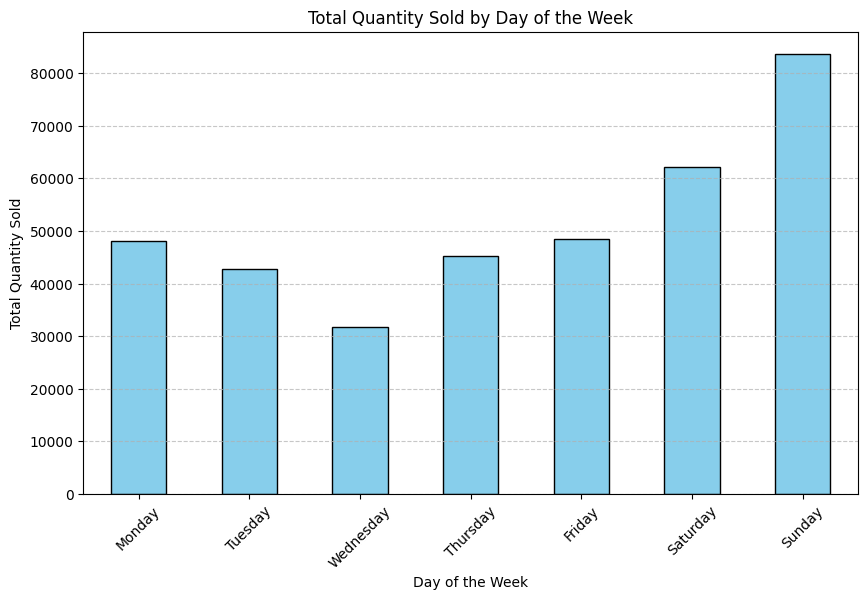

In [59]:
plt.figure(figsize=(10, 6))
byDay.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Total Quantity Sold by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Quantity Sold')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

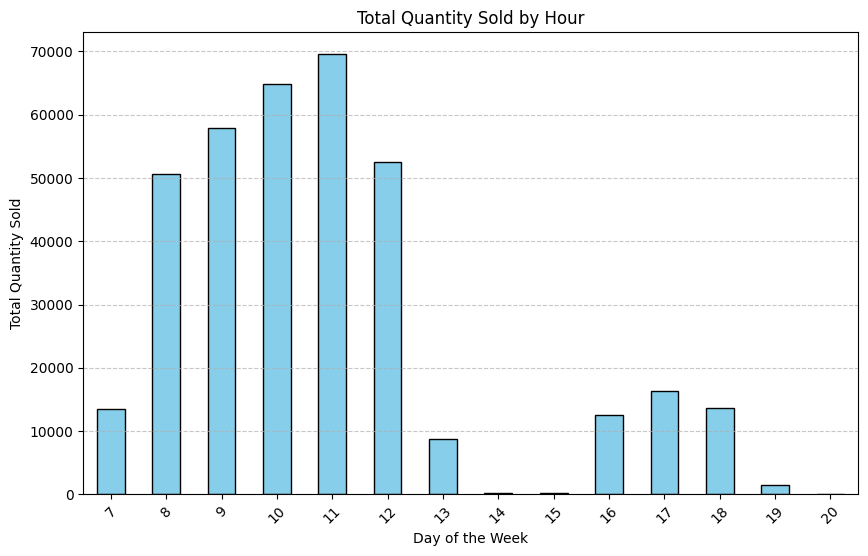

In [60]:
plt.figure(figsize=(10, 6))
byHour.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Total Quantity Sold by Hour')
plt.xlabel('Day of the Week')
plt.ylabel('Total Quantity Sold')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

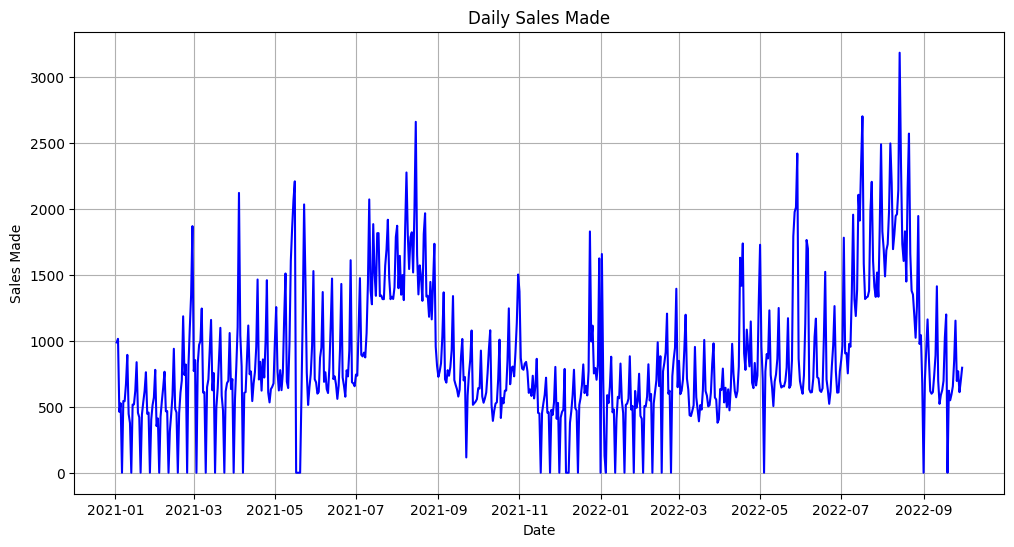

In [61]:
plt.figure(figsize=(12, 6))
plt.plot(dailySales.index, dailySales.values, linestyle='-', color='b')
plt.title('Daily Sales Made')
plt.xlabel('Date')
plt.ylabel('Sales Made')
plt.grid(True)
plt.show()

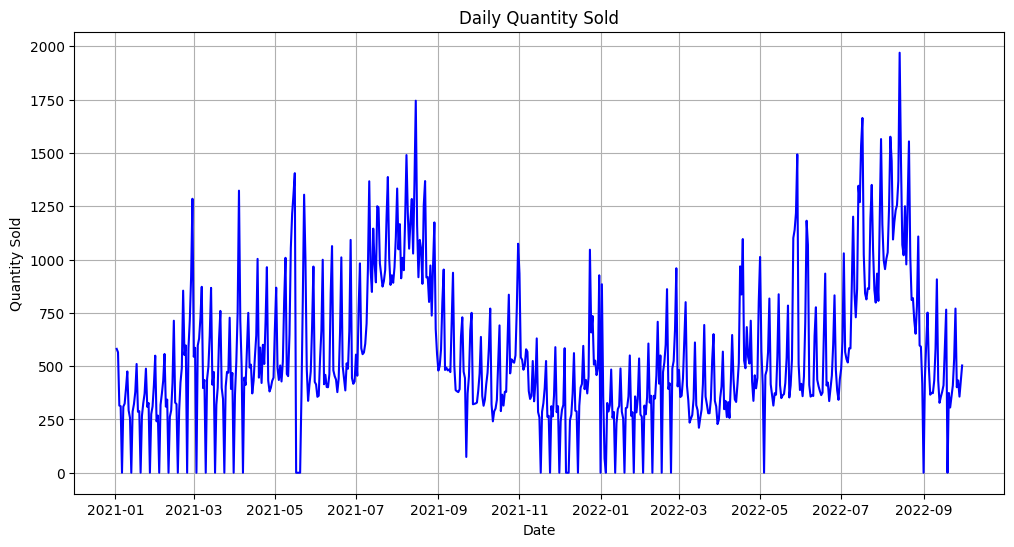

In [62]:
plt.figure(figsize=(12, 6))
plt.plot(dailyQuantity.index, dailyQuantity.values, linestyle='-', color='b')
plt.title('Daily Quantity Sold')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.grid(True)
plt.show()

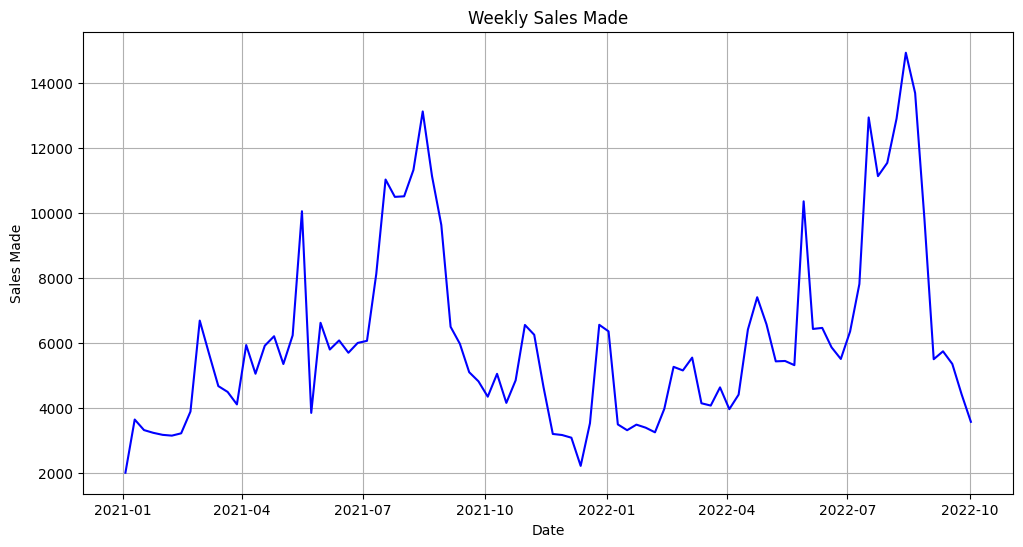

In [63]:
plt.figure(figsize=(12, 6))
plt.plot(weeklySales.index, weeklySales.values, linestyle='-', color='b')
plt.title('Weekly Sales Made')
plt.xlabel('Date')
plt.ylabel('Sales Made')
plt.grid(True)
plt.show()

# Modeling

## Seasonal Auto-Regressive Integrated Moving Average (SARIMA)

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

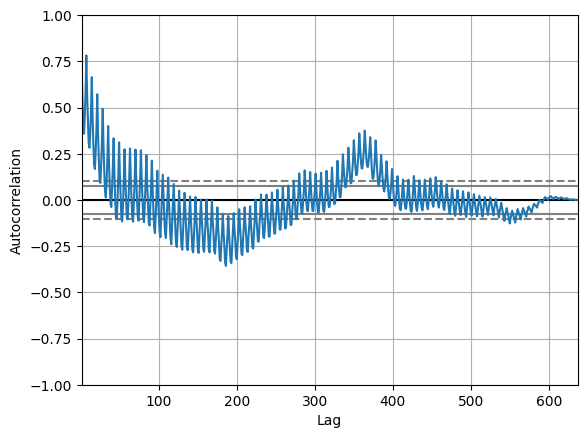

In [64]:
autocorrelation_plot(dailyQuantity)

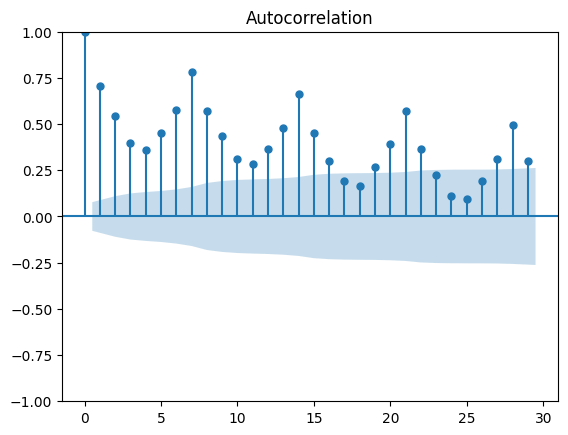

In [65]:
plot_acf(dailyQuantity)
plt.show()

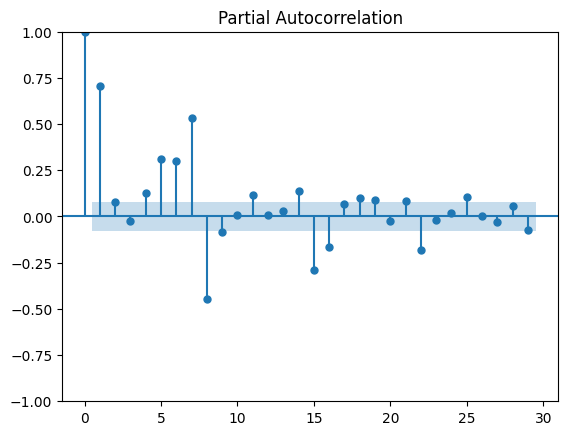

In [66]:
plot_pacf(dailyQuantity)
plt.show()

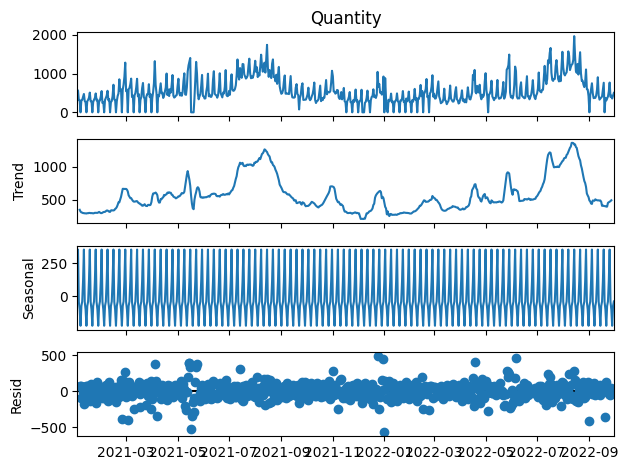

In [67]:
decomposition=seasonal_decompose(dailyQuantity,model='additive',period=7)
decomposition.plot()
plt.show()

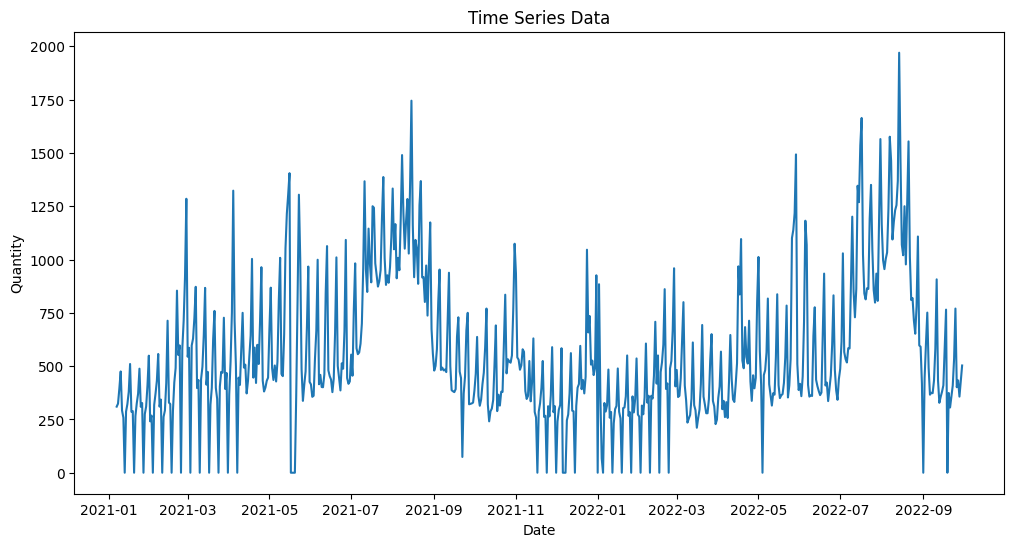

In [68]:
plt.figure(figsize=(12, 6))
plt.plot(dailyDf['Quantity'])
plt.title('Time Series Data')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.show()

In [69]:
def rolling_statistics(input):
    MA = input.rolling(window = 5).mean()
    MSTD = input.rolling(window = 5).std()

    plt.figure(figsize =(15,5))
    real = plt.plot(input, color = 'black',label = 'Actual')
    mean = plt.plot(MA,color = 'green', label ='Rolling Mean')
    std = plt.plot(MSTD, color ='blue', label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Std')
    plt.show(block = False)

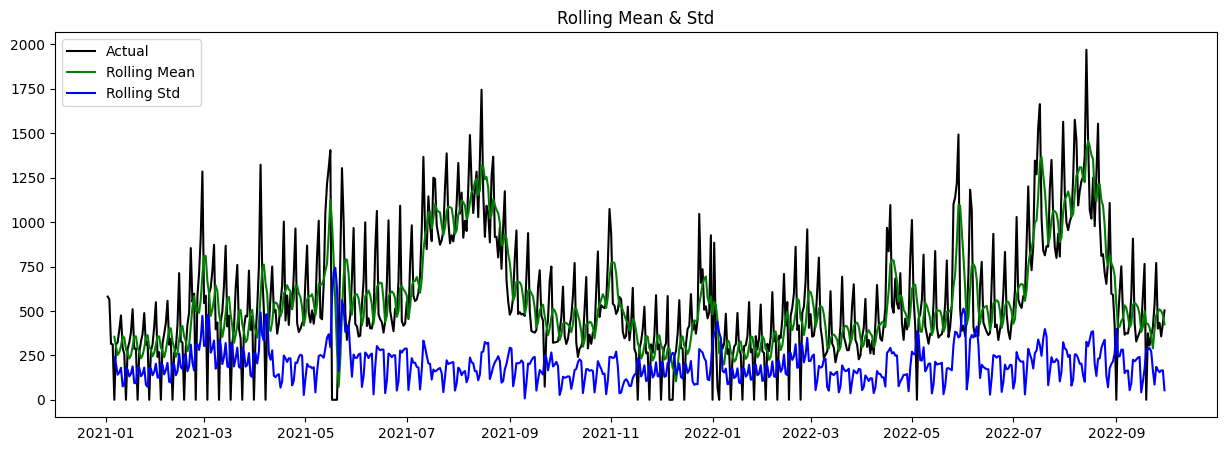

In [70]:
rolling_statistics(dailyQuantity)

In [71]:
dftestDaily = adfuller(dailyQuantity, autolag = 'AIC')
print("1. ADF : ",dftestDaily[0])
print("2. P-Value : ", dftestDaily[1])
print("3. Num Of Lags : ", dftestDaily[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftestDaily[3])
print("5. Critical Values :")
for key, val in dftestDaily[4].items():
    print("\t",key, ": ", val)

1. ADF :  -2.6320505342623615
2. P-Value :  0.08655232979405775
3. Num Of Lags :  20
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 616
5. Critical Values :
	 1% :  -3.4410103235939746
	 5% :  -2.866243374831338
	 10% :  -2.5692748053002195


In [72]:
trainDaily = dailyQuantity[:int(0.7*len(dailyQuantity))]
testDaily = dailyQuantity[int(0.7*len(dailyQuantity)):]

In [73]:
modelDaily =  pmd.auto_arima(dailyQuantity,start_p=1,start_q=1,test='adf',m=7,seasonal=True,trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=8196.842, Time=1.52 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=8869.710, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=8373.061, Time=0.23 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=8586.844, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=8867.711, Time=0.01 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=8498.621, Time=0.49 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(1,1,1)(2,0,1)[7] intercept   : AIC=inf, Time=1.93 sec
 ARIMA(1,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=2.24 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=8725.515, Time=0.22 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=inf, Time=0.80 sec
 ARIMA(1,1,1)(2,0,0)[7] intercept   : AIC=inf, Time=1.00 sec
 ARIMA(1,1,1)(2,0,2)[7] intercept   : AIC=inf, Time=2.28 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=8175.273, Time=1.32 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=8364.193, Time=0.22 s

In [74]:
sarimaTrainDaily=SARIMAX(trainDaily,order=(0,1,4),seasonal_order=(1,0,1,7))
predictedTrainDaily=sarimaTrainDaily.fit().predict()

In [75]:
sarimaTestDaily=SARIMAX(testDaily,order=(0,1,4),seasonal_order=(1,0,1,7))
predictedTestDaily=sarimaTestDaily.fit().predict()

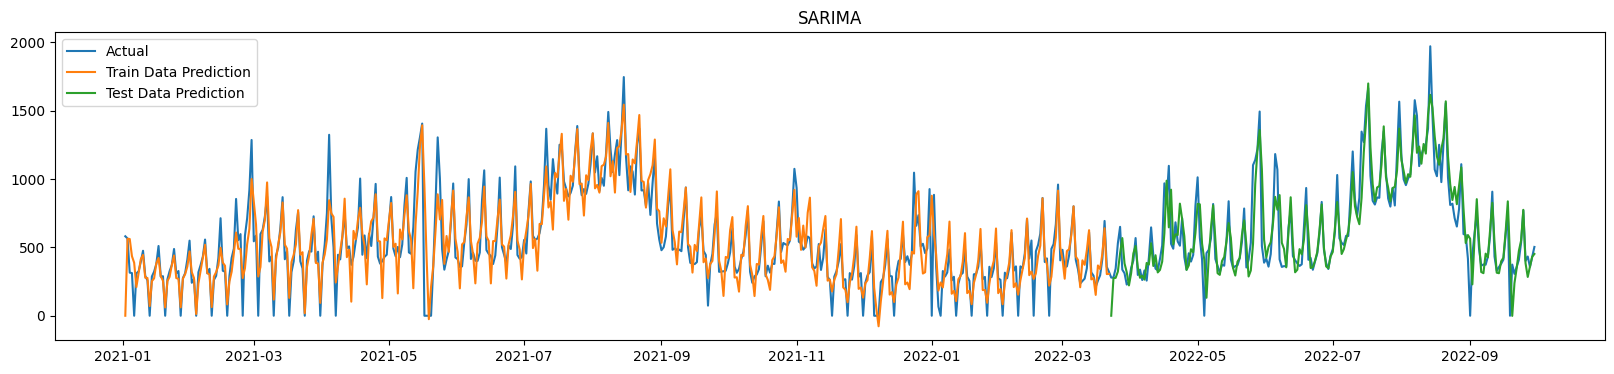

In [76]:
plt.figure(figsize=(20,4))
plt.plot(dailyQuantity,label='Actual')
plt.plot(predictedTrainDaily,label='Train Data Prediction')
plt.plot(predictedTestDaily,label='Test Data Prediction')
plt.title('SARIMA')
plt.legend()

In [78]:
residualsDaily = testDaily - predictedTestDaily
mae = mean_absolute_error(testDaily, predictedTestDaily)
rmse = np.sqrt(np.mean(residualsDaily**2))
print("MAE = ", mae)
print("RMSE = ", rmse)

MAE =  109.68133341007268
RMSE =  159.45838569945408


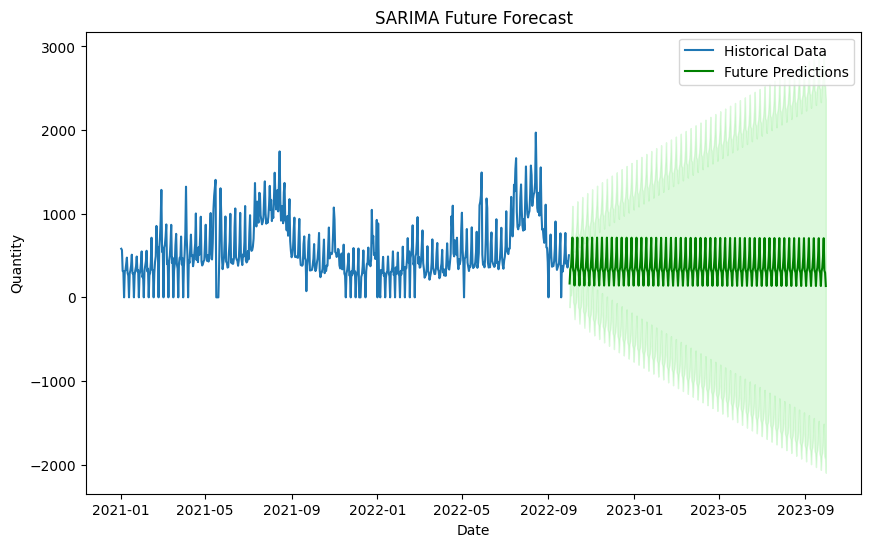

In [141]:
predictedTrainDaily = sarimaTrainDaily.fit(disp=False)

futureSteps = 365
futureModel = predictedTrainDaily.get_forecast(steps = futureSteps)
ftIndex = pd.date_range(start=testDaily.index[-1] + pd.offsets.DateOffset(days=1), periods=futureSteps, freq='D')
futurePred = futureModel.predicted_mean
futureConfInt = futureModel.conf_int()
plt.figure(figsize=(10, 6))
plt.plot(dailyQuantity, label='Historical Data')
plt.plot(ftIndex, futurePred, label='Future Predictions', color='green')
plt.fill_between(ftIndex, futureConfInt.iloc[:, 0], futureConfInt.iloc[:, 1], color='lightgreen', alpha=0.3)
plt.title('SARIMA Future Forecast')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()
plt.show()

## XGBOOST

In [142]:
trainXgbSizeDaily = int(len(dailyDf) * 0.7)
trainXgbDataDaily, testXgbDataDaily= dailyDf[:trainXgbSizeDaily], dailyDf[trainXgbSizeDaily:]

In [143]:
trainXgbDataDaily.columns

Index(['Quantity', 'price', 'total', 'month', 'year', 'quarter', 'dayofweek',
       'dayofyear', 'day', 'frHoliday', 'quantityYesterday', 'quantitylag2',
       'quantitylag3', 'quantitylag4', 'quantitylag5', 'rollingAvg5',
       'isFuture'],
      dtype='object')

In [144]:
dailyDf.head()

,Quantity,price,total,month,year,quarter,dayofweek,dayofyear,day,frHoliday,quantityYesterday,quantitylag2,quantitylag3,quantitylag4,quantitylag5,rollingAvg5,isFuture
date,,,,,,,,,,,,,,,,,
2021-01-07,310.0,428.30,544.00,1,2021,1,3,7,7,False,0.0,312.0,315.0,565.0,581.0,300.4,False
2021-01-08,324.0,438.05,542.05,1,2021,1,4,8,8,False,310.0,0.0,312.0,315.0,565.0,252.2,False
2021-01-09,395.0,512.40,672.95,1,2021,1,5,9,9,False,324.0,310.0,0.0,312.0,315.0,268.2,False
2021-01-10,475.0,709.90,893.45,1,2021,1,6,10,10,False,395.0,324.0,310.0,0.0,312.0,300.8,False
2021-01-11,292.0,346.85,446.05,1,2021,1,0,11,11,False,475.0,395.0,324.0,310.0,0.0,359.2,False


In [145]:
featuresDaily = ['month','year','quarter','dayofweek','dayofyear','day','frHoliday','quantityYesterday','quantitylag2','quantitylag3','quantitylag4','quantitylag5','rollingAvg5']
featuresDailyMod = ['month','year','quarter','dayofweek','dayofyear','day','frHoliday']
targetDaily = 'Quantity'

In [146]:
X_trainDaily = trainXgbDataDaily[featuresDaily]
y_trainDaily = trainXgbDataDaily[targetDaily]
X_testDaily = testXgbDataDaily[featuresDaily]
y_testDaily = testXgbDataDaily[targetDaily]


X_trainDailyMod = trainXgbDataDaily[featuresDailyMod]
X_testDailyMod = testXgbDataDaily[featuresDailyMod]

In [147]:
param_grid = {
    'learning_rate': [0.1, 0.2, 0.3],
    'max_depth': [3, 5, 6],
    'subsample': [0.5, 0.6, 0.7],
    'gamma': [0,1,2]
    
}

grid_search = GridSearchCV(XGBRegressor(), param_grid, cv=3)

grid_search.fit(X_trainDaily, y_trainDaily)

best_params = grid_search.best_params_
print(best_params)

{'gamma': 2, 'learning_rate': 0.3, 'max_depth': 6, 'subsample': 0.6}


In [148]:
xgb_modelDaily = XGBRegressor(gamma = 2,learning_rate = 0.3, max_depth = 6, subsample = 0.6)

xgb_modelDaily.fit(X_trainDaily, y_trainDaily)
predictionsDaily = xgb_modelDaily.predict(X_testDaily)

In [149]:
param_grid = {
    'learning_rate': [0.1, 0.2, 0.3],
    'max_depth': [3, 5, 6],
    'subsample': [0.5, 0.6, 0.7],
    'gamma': [0,1,2]
    
}

grid_search = GridSearchCV(XGBRegressor(), param_grid, cv=3)

grid_search.fit(X_trainDailyMod, y_trainDaily)

best_params = grid_search.best_params_
print(best_params)

{'gamma': 1, 'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.6}


In [150]:
xgb_modelDailyNoRoll = XGBRegressor(gamma = 1,learning_rate = 0.1, max_depth = 3, subsample = 0.6)

xgb_modelDailyNoRoll.fit(X_trainDailyMod, y_trainDaily)
predictionsDailyNoRoll = xgb_modelDailyNoRoll.predict(X_testDailyMod)

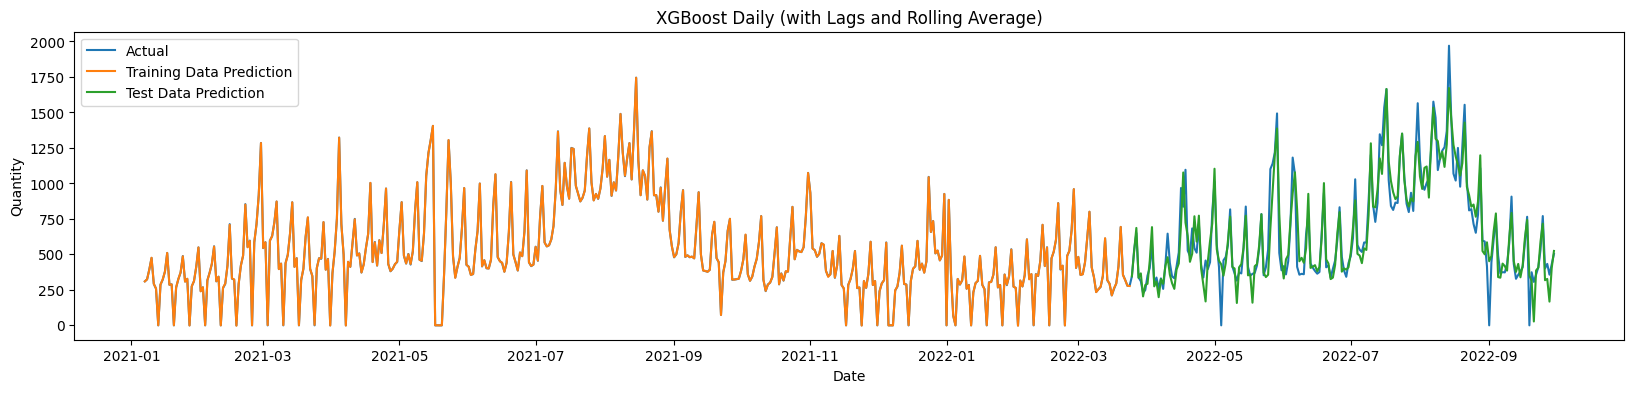

In [151]:
plt.figure(figsize=(20, 4))
plt.plot(dailyDf.index, dailyDf['Quantity'], label='Actual')

train_size = len(trainXgbDataDaily)
plt.plot(trainXgbDataDaily.index, xgb_modelDaily.predict(X_trainDaily), label='Training Data Prediction')

plt.plot(testXgbDataDaily.index, predictionsDaily, label='Test Data Prediction')

plt.title('XGBoost Daily (with Lags and Rolling Average)')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()

plt.show()

In [152]:
average_quantityDaily = dailyDf['Quantity'].mean()
print(f"Average Quantity: {average_quantityDaily}")

Average Quantity: 570.2784810126582


In [153]:
mae = mean_absolute_error(y_testDaily, predictionsDaily)

rmse = np.sqrt(mean_squared_error(y_testDaily, predictionsDaily))

print("Mean Absolute Error: ",mae)
print("Root Mean Squared Error: ", rmse)

Mean Absolute Error:  87.58344981544896
Root Mean Squared Error:  123.61168045734536


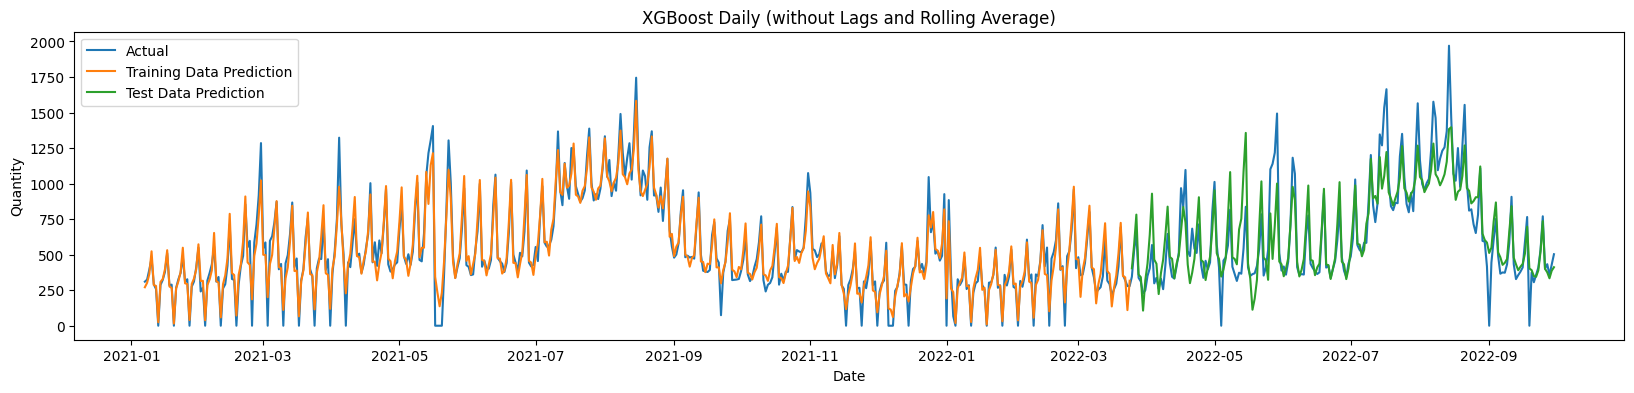

In [154]:
plt.figure(figsize=(20, 4))
plt.plot(dailyDf.index, dailyDf['Quantity'], label='Actual')

train_size = len(trainXgbDataDaily)
plt.plot(trainXgbDataDaily.index, xgb_modelDailyNoRoll.predict(X_trainDailyMod), label='Training Data Prediction')

plt.plot(testXgbDataDaily.index, predictionsDailyNoRoll, label='Test Data Prediction')

plt.title('XGBoost Daily (without Lags and Rolling Average)')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()

plt.show()

In [155]:
mae = mean_absolute_error(y_testDaily, predictionsDailyNoRoll)

rmse = np.sqrt(mean_squared_error(y_testDaily, predictionsDailyNoRoll))

print("Mean Absolute Error: ",mae)
print("Root Mean Squared Error: ", rmse)



Mean Absolute Error:  122.41874285246196
Root Mean Squared Error:  178.4687669473902


              Feature  Importance
3           dayofweek    0.277636
12        rollingAvg5    0.268814
7   quantityYesterday    0.162139
6           frHoliday    0.155961
9        quantitylag3    0.032880
4           dayofyear    0.030503
0               month    0.016386
8        quantitylag2    0.014029
11       quantitylag5    0.013856
10       quantitylag4    0.013558
5                 day    0.010431
1                year    0.003808
2             quarter    0.000000


Text(0, 0.5, 'Feature')

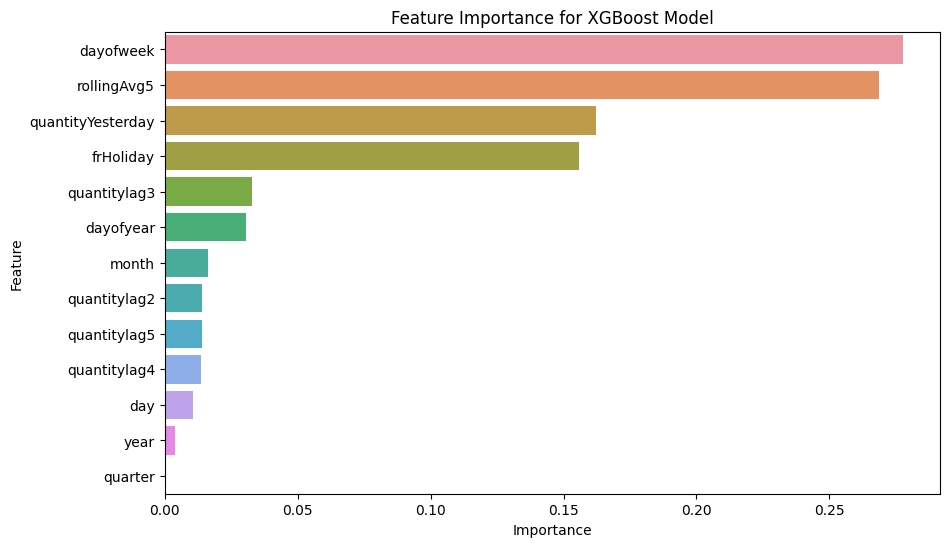

In [156]:
feature_importances = xgb_modelDaily.feature_importances_

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': featuresDaily,
    'Importance': feature_importances
})
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Print the feature importance DataFrame
print(feature_importance_df)

# Visualize the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance for XGBoost Model')
plt.xlabel('Importance')
plt.ylabel('Feature')

In [157]:
dailyDf.index.max()

Timestamp('2022-09-30 00:00:00')

In [158]:
dailyDf.tail()

,Quantity,price,total,month,year,quarter,dayofweek,dayofyear,day,frHoliday,quantityYesterday,quantitylag2,quantitylag3,quantitylag4,quantitylag5,rollingAvg5,isFuture
date,,,,,,,,,,,,,,,,,
2022-09-26,401.0,532.80,695.55,9,2022,3,0,269,26,False,770.0,534.0,409.0,357.0,306.0,494.2,False
2022-09-27,433.0,604.95,769.00,9,2022,3,1,270,27,False,401.0,770.0,534.0,409.0,357.0,509.4,False
2022-09-28,357.0,488.30,610.70,9,2022,3,2,271,28,False,433.0,401.0,770.0,534.0,409.0,499.0,False
2022-09-29,430.0,487.30,698.30,9,2022,3,3,272,29,False,357.0,433.0,401.0,770.0,534.0,478.2,False
2022-09-30,503.0,579.75,795.95,9,2022,3,4,273,30,False,430.0,357.0,433.0,401.0,770.0,424.8,False


In [159]:
futureCompleteDailyDfNoRollNoLag.drop(columns=['quantityYesterday','quantitylag2','quantitylag3','quantitylag4','rollingAvg5'], inplace = True)

In [160]:
futureCompleteDailyDfNoRollNoLag.head()

,Quantity,price,total,month,year,quarter,dayofweek,dayofyear,day,frHoliday,quantitylag5,isFuture
2022-09-29,NaN,NaN,NaN,9,2022,3,3,272,29,False,NaN,True
2022-09-30,NaN,NaN,NaN,9,2022,3,4,273,30,False,NaN,True
2022-10-01,NaN,NaN,NaN,10,2022,4,5,274,1,False,NaN,True
2022-10-02,NaN,NaN,NaN,10,2022,4,6,275,2,False,NaN,True
2022-10-03,NaN,NaN,NaN,10,2022,4,0,276,3,False,NaN,True


In [161]:
futureCompleteDailyDf.head()

,Quantity,price,total,month,year,quarter,dayofweek,dayofyear,day,frHoliday,quantityYesterday,quantitylag2,quantitylag3,quantitylag4,quantitylag5,rollingAvg5,isFuture
2022-10-01,NaN,NaN,NaN,10,2022,4,5,274,1,False,503.0,430.0,357.0,433.0,401.0,NaN,True
2022-10-02,NaN,NaN,NaN,10,2022,4,6,275,2,False,NaN,503.0,430.0,357.0,433.0,NaN,True
2022-10-03,NaN,NaN,NaN,10,2022,4,0,276,3,False,NaN,NaN,503.0,430.0,357.0,NaN,True
2022-10-04,NaN,NaN,NaN,10,2022,4,1,277,4,False,NaN,NaN,NaN,503.0,430.0,NaN,True
2022-10-05,NaN,NaN,NaN,10,2022,4,2,278,5,False,NaN,NaN,NaN,NaN,503.0,NaN,True


In [162]:
futureCompleteDailyDfCopy = futureCompleteDailyDf.copy()

In [163]:
futureCompleteDailyDfNoRollNoLagCopy = futureCompleteDailyDfNoRollNoLag.copy()

In [164]:
futureCompleteDailyDf['forecastDaily'] = xgb_modelDaily.predict(futureCompleteDailyDf[featuresDaily])

In [165]:
futureCompleteDailyDfNoRollNoLag['forecastDailyNoRollNoLag'] = xgb_modelDailyNoRoll.predict(futureCompleteDailyDfNoRollNoLag[featuresDailyMod])

In [166]:
futureCompleteDailyDf['forecastDaily']

2022-10-01    1087.776245
2022-10-02    1350.928467
2022-10-03    1039.397095
2022-10-04    1060.200928
2022-10-05    1053.610474
2022-10-06    1019.451233
2022-10-07    1008.453735
2022-10-08    1140.186890
2022-10-09    1208.743774
2022-10-10     909.894287
2022-10-11    1031.140015
2022-10-12    1024.601196
2022-10-13    1024.750854
2022-10-14    1008.173218
2022-10-15    1136.063232
2022-10-16    1204.031494
2022-10-17     916.107422
2022-10-18    1045.777222
2022-10-19    1072.143799
2022-10-20    1096.103760
2022-10-21    1096.484497
2022-10-22    1237.524170
2022-10-23    1294.664307
2022-10-24     991.908386
2022-10-25    1125.010254
2022-10-26    1125.206055
2022-10-27    1124.989990
2022-10-28    1126.225830
2022-10-29    1265.672607
2022-10-30    1325.823853
2022-10-31    1003.229065
2022-11-01    1134.210205
2022-11-02    1018.065063
2022-11-03    1018.364563
2022-11-04    1004.252197
2022-11-05    1132.437256
2022-11-06    1209.608765
2022-11-07     908.612183
2022-11-08  

In [167]:
futureCompleteDailyDfNoRollNoLag['forecastDailyNoRollNoLag']

2022-09-29     387.140167
2022-09-30     411.607361
2022-10-01     470.660797
2022-10-02     669.443787
2022-10-03     385.813171
2022-10-04     358.459625
2022-10-05     317.883392
2022-10-06     344.152100
2022-10-07     373.936890
2022-10-08     481.496216
2022-10-09     663.707825
2022-10-10     369.346191
2022-10-11     346.948181
2022-10-12     308.249634
2022-10-13     339.080658
2022-10-14     386.826447
2022-10-15     506.182587
2022-10-16     697.210938
2022-10-17     322.481689
2022-10-18     327.064423
2022-10-19     285.152191
2022-10-20     322.367828
2022-10-21     366.464874
2022-10-22     497.928528
2022-10-23     748.594482
2022-10-24     443.058411
2022-10-25     437.197998
2022-10-26     427.843445
2022-10-27     478.331482
2022-10-28     510.300476
2022-10-29     620.135986
2022-10-30     813.007812
2022-10-31     558.359802
2022-11-01     818.349365
2022-11-02     387.491455
2022-11-03     407.974152
2022-11-04     438.295502
2022-11-05     514.764099
2022-11-06  

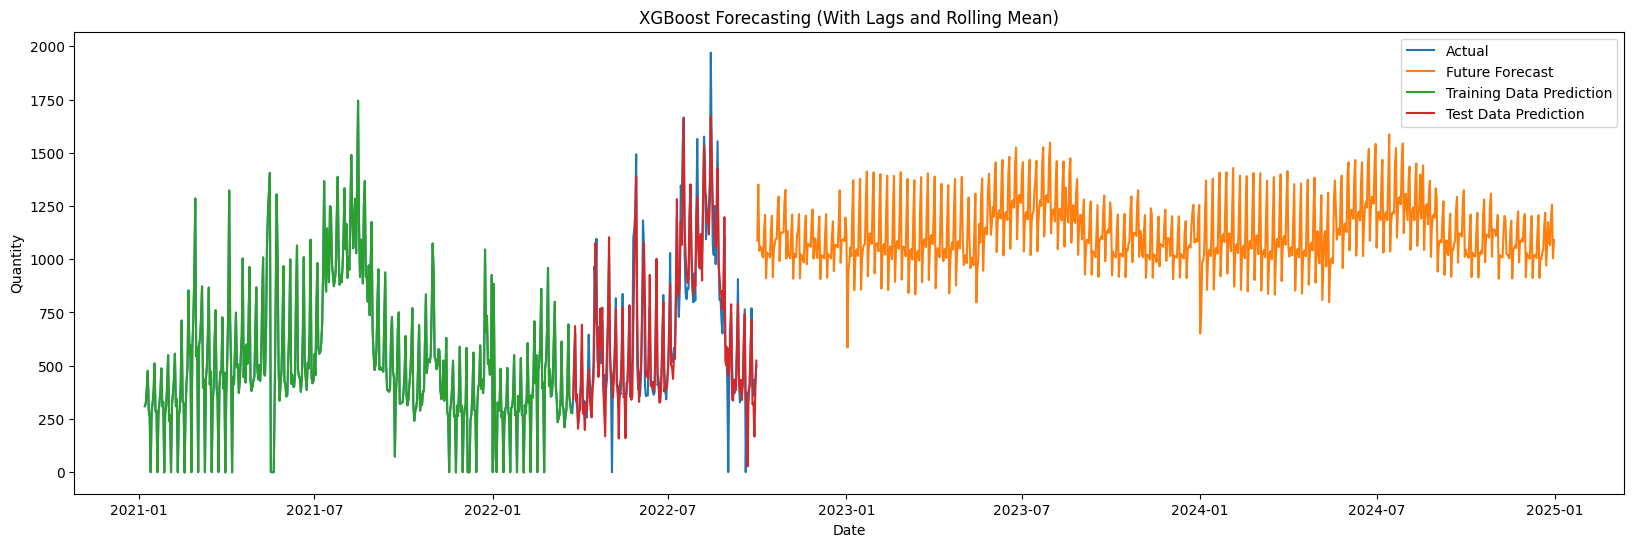

In [168]:
plt.figure(figsize = (20,6))
plt.plot(dailyDf.index,dailyDf['Quantity'], label = 'Actual')
plt.plot(futureCompleteDailyDf.index,futureCompleteDailyDf['forecastDaily'], label = 'Future Forecast')
plt.plot(trainXgbDataDaily.index, xgb_modelDaily.predict(X_trainDaily), label='Training Data Prediction')

plt.plot(testXgbDataDaily.index, predictionsDaily, label='Test Data Prediction')
plt.title('XGBoost Forecasting (With Lags and Rolling Mean)')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()

plt.show()

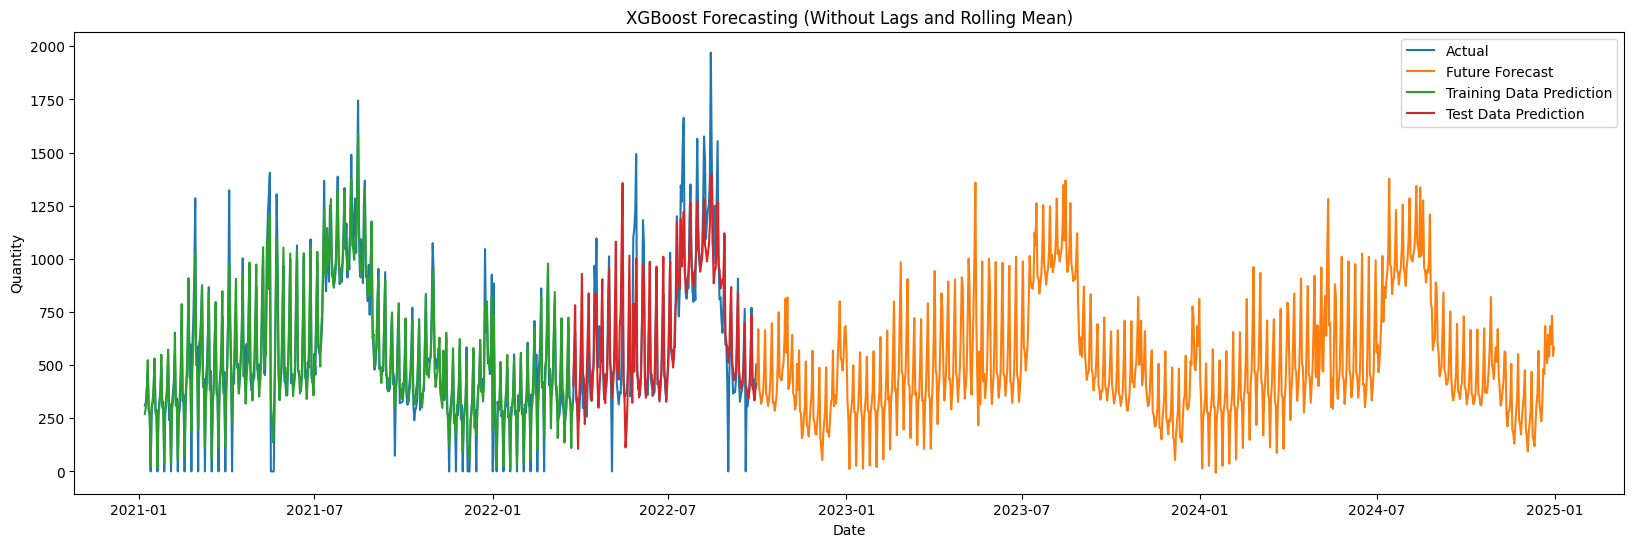

In [169]:
plt.figure(figsize = (20,6))
plt.plot(dailyDf.index,dailyDf['Quantity'], label = 'Actual')
plt.plot(futureCompleteDailyDfNoRollNoLag.index,futureCompleteDailyDfNoRollNoLag['forecastDailyNoRollNoLag'], label = 'Future Forecast')
plt.plot(trainXgbDataDaily.index, xgb_modelDailyNoRoll.predict(X_trainDailyMod), label='Training Data Prediction')

plt.plot(testXgbDataDaily.index, predictionsDailyNoRoll, label='Test Data Prediction')
plt.title('XGBoost Forecasting (Without Lags and Rolling Mean)')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()

plt.show()

In [170]:
futureCompleteDailyDf.head()

,Quantity,price,total,month,year,quarter,dayofweek,dayofyear,day,frHoliday,quantityYesterday,quantitylag2,quantitylag3,quantitylag4,quantitylag5,rollingAvg5,isFuture,forecastDaily
2022-10-01,NaN,NaN,NaN,10,2022,4,5,274,1,False,503.0,430.0,357.0,433.0,401.0,NaN,True,1087.776245
2022-10-02,NaN,NaN,NaN,10,2022,4,6,275,2,False,NaN,503.0,430.0,357.0,433.0,NaN,True,1350.928467
2022-10-03,NaN,NaN,NaN,10,2022,4,0,276,3,False,NaN,NaN,503.0,430.0,357.0,NaN,True,1039.397095
2022-10-04,NaN,NaN,NaN,10,2022,4,1,277,4,False,NaN,NaN,NaN,503.0,430.0,NaN,True,1060.200928
2022-10-05,NaN,NaN,NaN,10,2022,4,2,278,5,False,NaN,NaN,NaN,NaN,503.0,NaN,True,1053.610474


# RANDOM FOREST

In [171]:
rfparam_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3,5,7]
}

rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(estimator = rf, param_grid=rfparam_grid, cv=3, n_jobs = -1, verbose = 2)

grid_search.fit(X_trainDaily, y_trainDaily)

rfbest_params = grid_search.best_params_
print("Best RF Perimeters: ",rfbest_params)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best RF Perimeters:  {'max_depth': 7, 'n_estimators': 50}


In [172]:
rfparam_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3,5,7]
}

rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(estimator = rf, param_grid=rfparam_grid, cv=3, n_jobs = -1, verbose = 2)

grid_search.fit(X_trainDailyMod, y_trainDaily)

rfbest_params = grid_search.best_params_
print("Best RF Perimeters: ",rfbest_params)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best RF Perimeters:  {'max_depth': 7, 'n_estimators': 200}


In [173]:
rfModelDaily = RandomForestRegressor(n_estimators = 50, max_depth = 7)
rfModelDaily.fit(X_trainDaily,y_trainDaily)

RandomForestRegressor(max_depth=7, n_estimators=50)

In [174]:
rfModelDailyNoRollNoLag = RandomForestRegressor(n_estimators = 200, max_depth = 7)
rfModelDailyNoRollNoLag.fit(X_trainDailyMod, y_trainDaily)

RandomForestRegressor(max_depth=7, n_estimators=200)

In [175]:
rfPredDaily = rfModelDaily.predict(X_testDaily)
mae = mean_absolute_error(y_testDaily, rfPredDaily)
rmse = np.sqrt(mean_squared_error(y_testDaily, rfPredDaily))

print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")


Mean Absolute Error: 99.5223765400259
Root Mean Squared Error: 140.65505287550383


In [176]:
rfPredDailyNoRollNoLag = rfModelDailyNoRollNoLag.predict(X_testDailyMod)
mae = mean_absolute_error(y_testDaily, rfPredDailyNoRollNoLag)
rmse = np.sqrt(mean_squared_error(y_testDaily, rfPredDailyNoRollNoLag))

print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")

Mean Absolute Error: 119.00310895557277
Root Mean Squared Error: 170.51176927493404


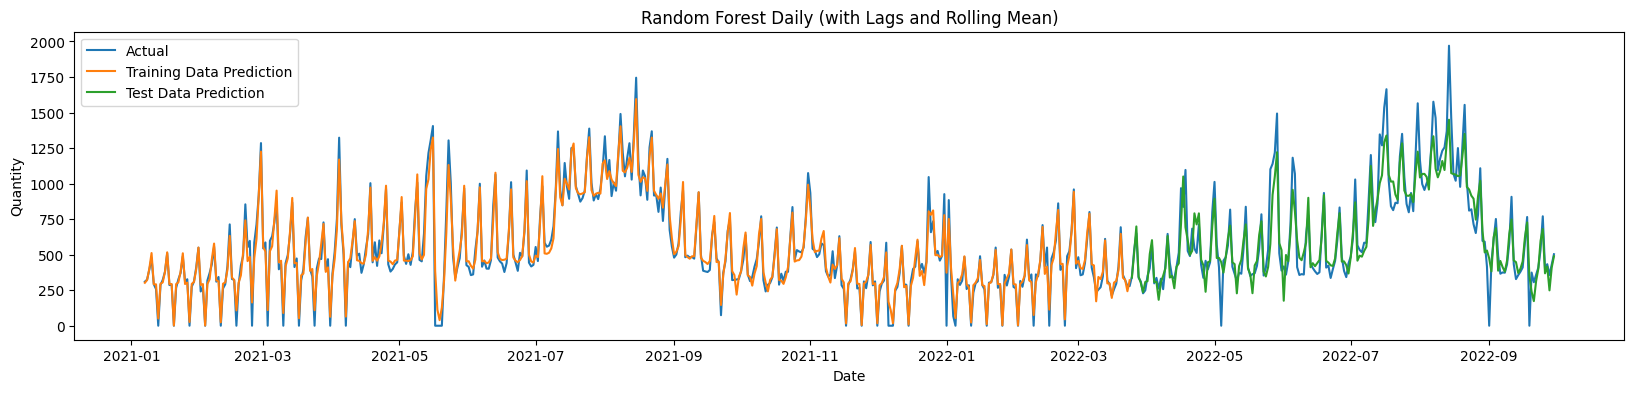

In [177]:
plt.figure(figsize=(20, 4))
plt.plot(dailyDf.index, dailyDf['Quantity'], label='Actual')

train_size = len(trainXgbDataDaily)
plt.plot(trainXgbDataDaily.index, rfModelDaily.predict(X_trainDaily), label='Training Data Prediction')

plt.plot(testXgbDataDaily.index, rfPredDaily, label='Test Data Prediction')

plt.title('Random Forest Daily (with Lags and Rolling Mean)')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()

plt.show()

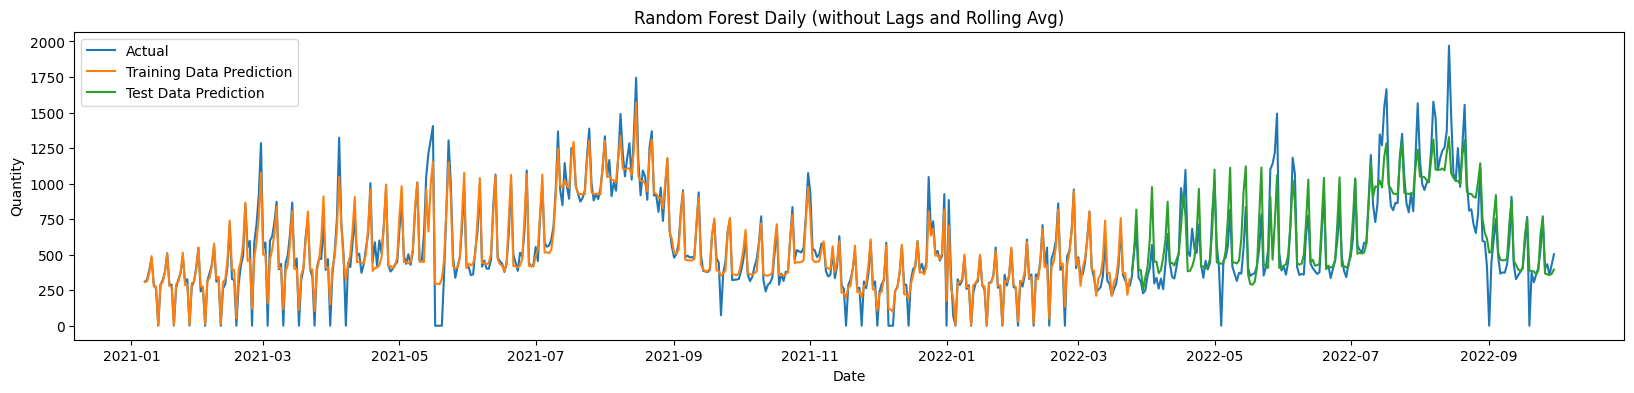

In [178]:
plt.figure(figsize=(20, 4))
plt.plot(dailyDf.index, dailyDf['Quantity'], label='Actual')

train_size = len(trainXgbDataDaily)
plt.plot(trainXgbDataDaily.index, rfModelDailyNoRollNoLag.predict(X_trainDailyMod), label='Training Data Prediction')

plt.plot(testXgbDataDaily.index, rfPredDailyNoRollNoLag, label='Test Data Prediction')

plt.title('Random Forest Daily (without Lags and Rolling Avg)')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()

plt.show()

In [179]:
futureCompleteDailyDfCopy['forecastRF'] = rfModelDaily.predict(futureCompleteDailyDf[featuresDaily])
futureCompleteDailyDfCopy['forecastRF']

2022-10-01    628.583804
2022-10-02    582.687992
2022-10-03    306.177571
2022-10-04    353.198197
2022-10-05    329.671589
2022-10-06    380.631140
2022-10-07    446.203666
2022-10-08    596.453273
2022-10-09    621.195374
2022-10-10    359.779443
2022-10-11    361.706423
2022-10-12    339.771593
2022-10-13    379.800854
2022-10-14    446.203666
2022-10-15    597.884511
2022-10-16    622.626612
2022-10-17    358.949158
2022-10-18    361.706423
2022-10-19    339.771593
2022-10-20    379.800854
2022-10-21    446.203666
2022-10-22    602.387011
2022-10-23    632.742446
2022-10-24    358.949158
2022-10-25    362.497958
2022-10-26    340.563128
2022-10-27    380.592388
2022-10-28    446.203666
2022-10-29    602.387011
2022-10-30    632.130065
2022-10-31    368.923378
2022-11-01    385.023702
2022-11-02    340.601879
2022-11-03    380.631140
2022-11-04    446.203666
2022-11-05    591.133875
2022-11-06    611.536810
2022-11-07    359.779443
2022-11-08    362.536709
2022-11-09    340.601879


In [180]:
futureCompleteDailyDfNoRollNoLagCopy['forecastRF'] = rfModelDailyNoRollNoLag.predict(futureCompleteDailyDfNoRollNoLag[featuresDailyMod])
futureCompleteDailyDfNoRollNoLagCopy['forecastRF']

2022-09-29     364.562359
2022-09-30     396.111068
2022-10-01     546.903467
2022-10-02     658.455209
2022-10-03     373.372885
2022-10-04     366.127952
2022-10-05     361.000075
2022-10-06     368.995215
2022-10-07     384.209714
2022-10-08     565.685709
2022-10-09     707.803588
2022-10-10     362.495432
2022-10-11     356.588853
2022-10-12     352.293492
2022-10-13     360.242068
2022-10-14     374.543434
2022-10-15     575.205736
2022-10-16     705.396344
2022-10-17     356.908667
2022-10-18     353.932076
2022-10-19     352.216986
2022-10-20     361.056372
2022-10-21     376.846647
2022-10-22     604.149734
2022-10-23     756.433374
2022-10-24     411.069579
2022-10-25     438.728096
2022-10-26     445.031159
2022-10-27     447.934034
2022-10-28     461.923118
2022-10-29     706.653337
2022-10-30     896.309073
2022-10-31     482.209211
2022-11-01     766.116629
2022-11-02     463.864617
2022-11-03     454.487845
2022-11-04     456.848372
2022-11-05     531.397241
2022-11-06  

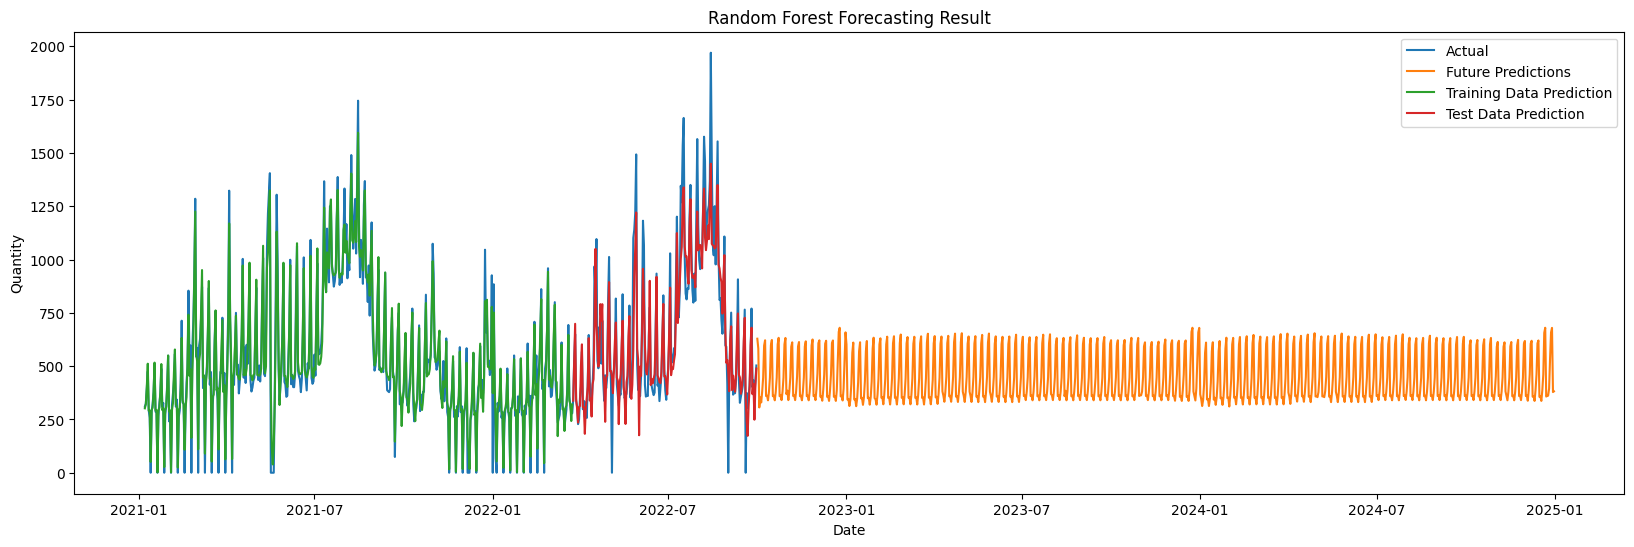

In [181]:
plt.figure(figsize=(20,6))
plt.plot(dailyDf.index, dailyDf['Quantity'], label='Actual')
plt.plot(futureCompleteDailyDfCopy.index, futureCompleteDailyDfCopy['forecastRF'], label='Future Predictions')
plt.plot(trainXgbDataDaily.index, rfModelDaily.predict(X_trainDaily), label='Training Data Prediction')

plt.plot(testXgbDataDaily.index, rfPredDaily, label='Test Data Prediction')
plt.title('Random Forest Forecasting Result')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()

plt.show()

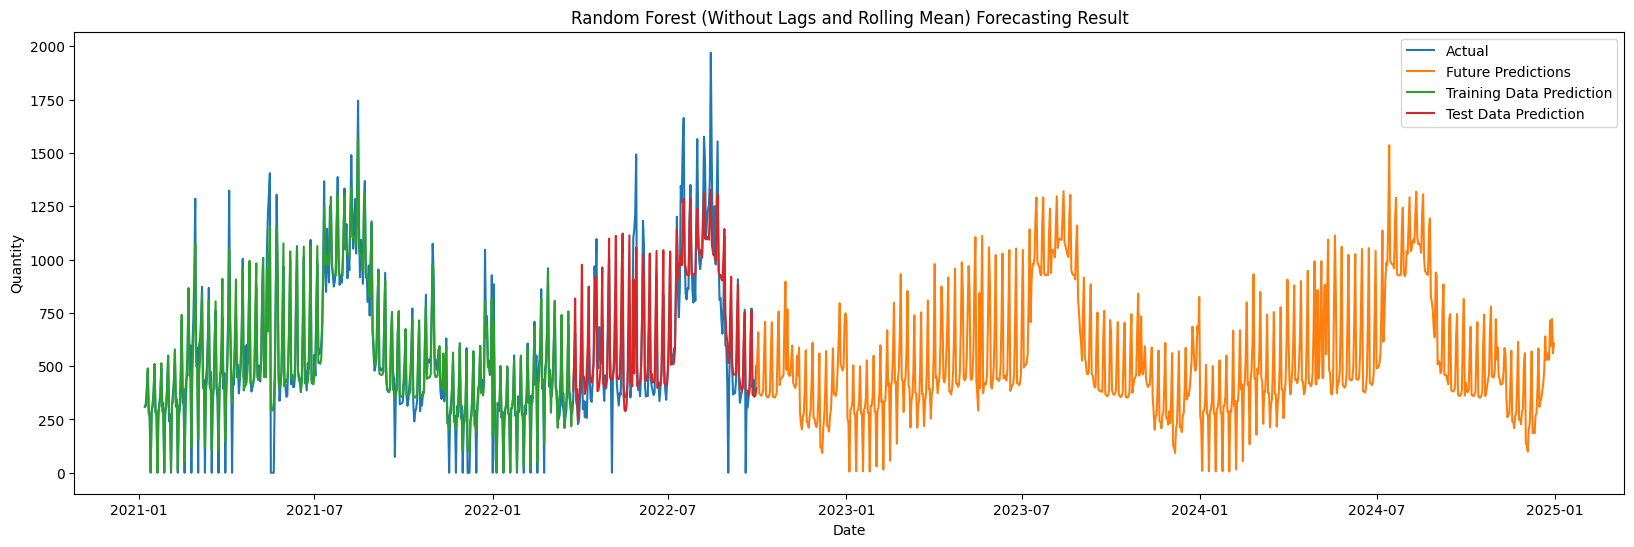

In [182]:
plt.figure(figsize=(20,6))
plt.plot(dailyDf.index, dailyDf['Quantity'], label='Actual')
plt.plot(futureCompleteDailyDfNoRollNoLagCopy.index, futureCompleteDailyDfNoRollNoLagCopy['forecastRF'], label='Future Predictions')
plt.plot(trainXgbDataDaily.index, rfModelDailyNoRollNoLag.predict(X_trainDailyMod), label='Training Data Prediction')

plt.plot(testXgbDataDaily.index, rfPredDailyNoRollNoLag, label='Test Data Prediction')
plt.title('Random Forest (Without Lags and Rolling Mean) Forecasting Result')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()

plt.show()

In [ ]:
series = futureCompleteDailyDf['forecastDaily']
forecastDf = series.to_frame(name='Amount of Bread')
forecastDf.index = pd.to_datetime(forecastDf.index)

In [ ]:
forecastDf =tsFeature(forecastDf)
forecastDf.head()

,Amount of Bread,month,year,quarter,dayofweek,dayofyear,day
2022-10-01,1087.776245,10,2022,4,5,274,1
2022-10-02,1350.928467,10,2022,4,6,275,2
2022-10-03,1039.397095,10,2022,4,0,276,3
2022-10-04,1060.200928,10,2022,4,1,277,4
2022-10-05,1053.610474,10,2022,4,2,278,5


In [ ]:
forecastDf.drop(columns=['dayofweek','dayofyear','day'], inplace = True)

In [ ]:
forecastDf.head()

,Amount of Bread,month,year,quarter,dayofweek,dayofyear,day
2022-10-01,1087.776245,10,2022,4,5,274,1
2022-10-02,1350.928467,10,2022,4,6,275,2
2022-10-03,1039.397095,10,2022,4,0,276,3
2022-10-04,1060.200928,10,2022,4,1,277,4
2022-10-05,1053.610474,10,2022,4,2,278,5


In [ ]:
forecastDf.to_csv('dailyForecastResultFinal3.csv')